# plot

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great 
import bindome as bd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import pandas as pd 
import numpy as np 

import time

In [3]:
test = "../data/tests/test_data/input/01_random.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"

## Count plot

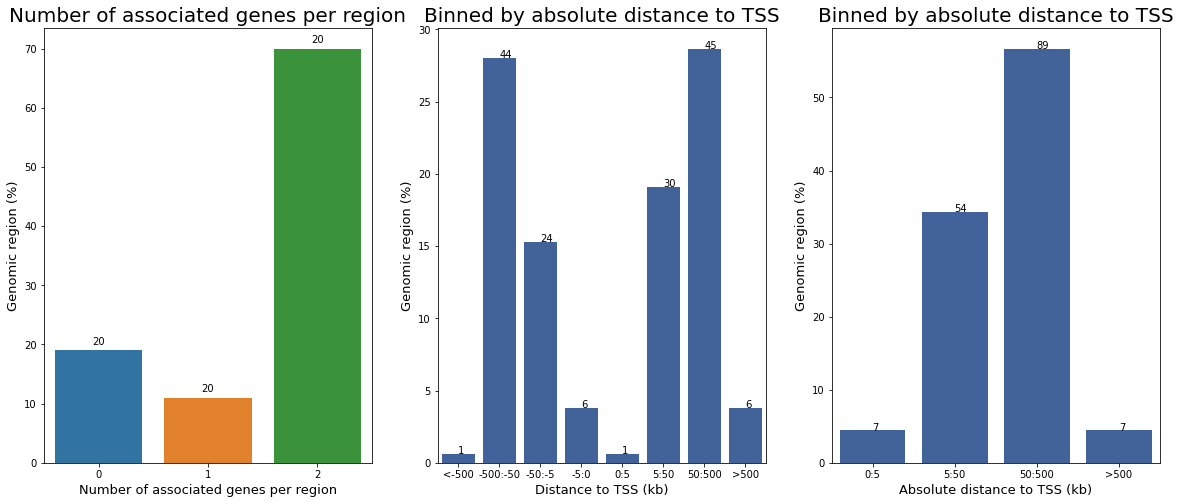

In [4]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
great.pl.graph_nb_asso_per_peaks(test,regdom,ax[0])
great.pl.graph_dist_tss(test,regdom,ax[1])
great.pl.graph_absolute_dist_tss(test,regdom,ax[2])
plt.show()

## Dotplot

In [5]:
enrichment = great.tl.GREAT.enrichment(
    test,
    regdom,
    "../data/human/hg38/chr_size.bed", 
    "../data/human/ontologies.csv"
)

In [6]:
enrichment

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall
GO:0045887,positive regulation of synaptic growth at neur...,5.20389e-13,2.18004e+05,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0044721,"protein import into peroxisome matrix, substra...",4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0036250,peroxisome transport along microtubule,4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0016561,"protein import into peroxisome matrix, translo...",6.31855e-10,3.68645e+04,6.16839e-03,1.61871e+02,4,2.00000e+00
GO:0030576,Cajal body organization,1.49190e-09,2.97236e+04,1.83932e-02,5.39569e+01,4,6.66667e-01
...,...,...,...,...,...,...,...
GO:0006355,"regulation of transcription, DNA-templated",9.93956e-01,2.08617e+01,8.40449e-01,5.54352e-01,1,1.71233e-03
GO:0006915,apoptotic process,9.95014e-01,2.01230e+01,5.39651e-01,1.11443e+00,1,1.72117e-03
GO:0042803,protein homodimerization activity,9.98551e-01,2.44788e+01,9.54394e-01,3.33067e-01,2,2.05761e-03
GO:0005737,cytoplasm,9.98903e-01,6.55886e+01,9.92060e-01,5.70469e-01,24,4.22907e-03


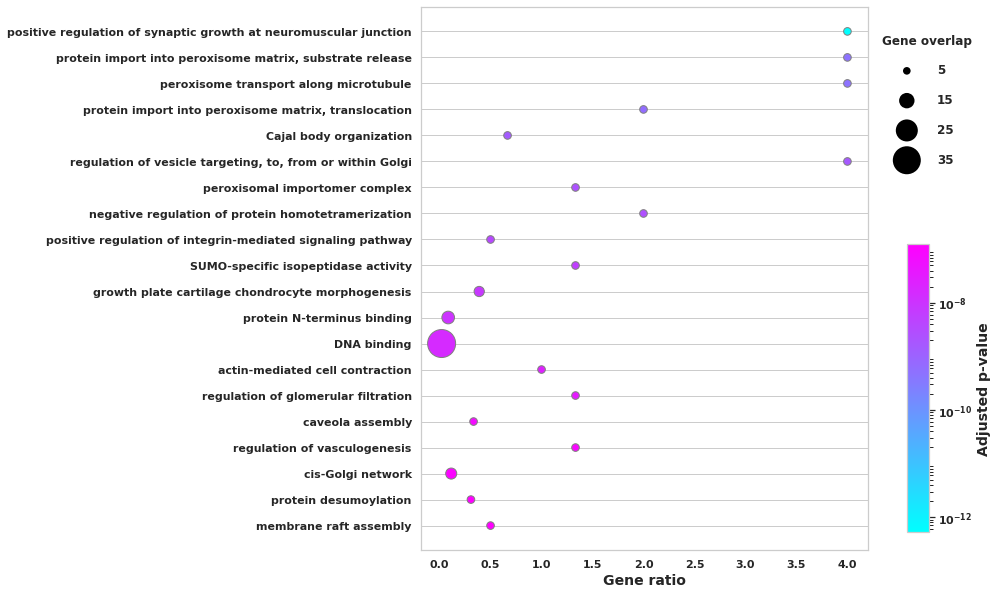

In [7]:
plot = enrichment.rename(columns={"binom_p_value" : "p_value", "go_term":"name"})
plt.figure(figsize=(10,10))
great.pl.plot_enrich(plot)

In [22]:
test = ["SRF:Ishikawa,MCF-7,HCT-116","SRF:Ishikawa,GM12878,A-673-clone-Asp114,K-562,MCF-7",
    "SRF:Hep-G2,K-562","SRF:Ishikawa,GM12878,K-562","SRF:Ishikawa,GM12878,K-562,WA01,MCF-7,Hep-G2",
    "SRF:K-562,Hep-G2","SRF:Ishikawa,GM12878,WA01,Hep-G2","SRF:WA01,K-562",
    "SRF:Ishikawa,GM12878,A-673-clone-Asp114,WA01,MCF-7,HCT-116,Hep-G2", 
    "SRF:GM12878,Ishikawa,MCF-7,A-673-clone-Asp114"]


def dotplot(test_data,annpath, n_row:int = 5,fig = None): 
    """
    Dotplot of enrichment GO terms for a given list of example genomic regions.

    Parameters
    ----------
    n_row : int
        Number of rows pick in each dataframe. 
    test_data : list
        List of biosample in SRF to be tested.

    Returns
    -------
    None.


    """
    min_p,min_od,max_p,max_od = 100,100,0,0
    bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath
    srf = bd.bindome.datasets.REMAP2020.get_remap_peaks('SRF')
    df = pd.DataFrame()

    for i,name in enumerate(test_data) :
        tmp = srf[srf[3]==name].iloc[:,0:3]
        tmp = tmp.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

        res = great.tl.GREAT.enrichment(
            test_file = tmp,
            regdom_file="../data/human/hg38/regulatory_domain.bed",
            chr_size_file="../data/human/hg38/chr_size.bed",
            annotation_file="../data/human/ontologies.csv",
            binom=True,
            hypergeom=True,
            ).sort_values(by="hypergeom_p_value").iloc[:n_row]

        res = res.reset_index().rename(columns={"index":"id"})
        res["index"] = [i]*n_row
        frames = [df, res]
        df = pd.concat(frames)

        time.sleep(30)

        print(f"done ... {i}")

    df["hypergeom_p_value"] = -np.log(df["hypergeom_p_value"])
    df["hypergeometric_fold_enrichment"] = np.log2(df["hypergeometric_fold_enrichment"])

    p_val = df.pivot("id","index","hypergeom_p_value").fillna(1)
    odd_ratio = df.pivot("id","index","hypergeometric_fold_enrichment").fillna(0)

    for i in p_val.columns : 
        if min_p > p_val[i].min() : 
            min_p = p_val[i].min()
        if max_p < p_val[i].max() : 
            max_p = p_val[i].max()

    for i in odd_ratio.columns : 
        if min_od > odd_ratio[i].min() : 
            min_od = odd_ratio[i].min()
        if max_od < odd_ratio[i].max() : 
            max_od = odd_ratio[i].max()
    

    plt.rcParams.update({"font.size": 14, "font.weight": "bold"})
    
    great.pl.make_bubble_heatmap(
        p_val,odd_ratio,quantAmplifier = 7,circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],palette_id="Reds",
        ylab='',xlab='', tickscolorbar=[i for i in range(round(min_p),round(max_p)+1)],vmin=min_p,vmax=max_p, cbar_label='-log(p_hypergeometric)',
        marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",sig_line_width=0.1, 
        fig=fig
        )
    
    return p_val,odd_ratio

done ... 0
done ... 1
done ... 2
done ... 3
done ... 4
done ... 5
done ... 6
done ... 7
done ... 8
done ... 9


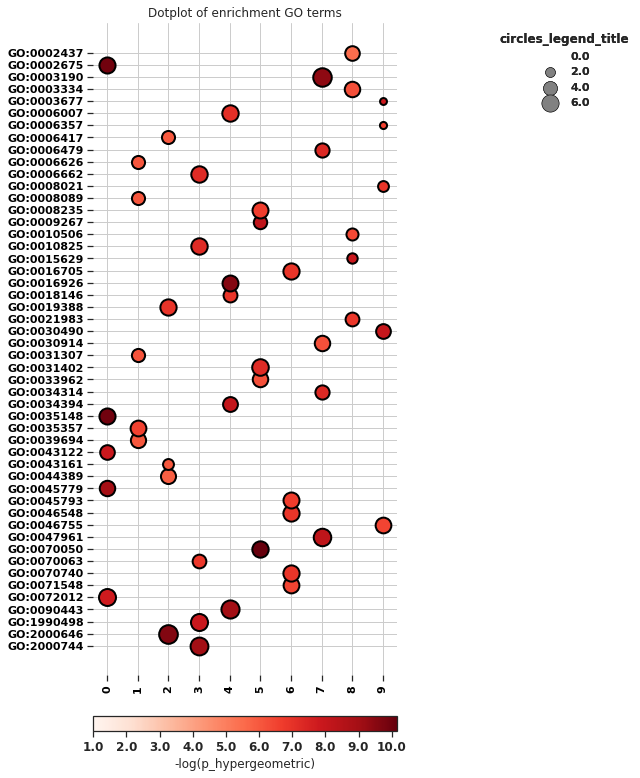

In [9]:
fig = plt.figure(figsize=(25, 15))
p_val,odd_ratio = dotplot(test,annpath="../../annotation/",fig=fig)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors, rcParams
from numpy import log

import greatpy as gp


def scatterplot(
    great_df: pd.DataFrame, colname_x: str, colname_y: str, title: str = "", minus_log10=True, ax=None
) -> None:
    """
    Create a scatterplot from a
    pandas dataframe between two columns.
    A logarithmic scale can be used.

    Parameters
    ----------
    great_df : pd.DataFrame
        Output of the greatpy.tl.GREAT.enrichment function
    colname_x : str
        Name of the column to be used as x axis
    colname_y : str
        Name of the column to be used as y axis
    title : str
        Title of the plot
    minus_log10 : bool
        If True, the logarithmic scale is used
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    great_df = great_df.dropna()
    great_df = great_df.astype({colname_x: "float64", colname_y: "float64"})
    if minus_log10:
        great_df[f"-log({colname_x})"] = -log(great_df[colname_x])
        great_df[f"-log({colname_y})"] = -log(great_df[colname_y])
        sns.scatterplot(data=great_df, x=f"-log({colname_x})", y=f"-log({colname_y})", ax=ax).set_title(title)
    else:
        sns.scatterplot(data=great_df, x=colname_x, y=colname_y, ax=ax).set_title(title)

def graph_nb_asso_per_peaks(test: str or pd.DataFrame, regdom: str or pd.DataFrame, ax=None, color=None) -> None:
    """
    Creates a barplot representing the
    percentage of peaks for all possible association numbers

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    nb_asso_per_peaks = gp.tl.get_nb_asso_per_region(test, regdom)

    nb = {
        "number": [],
        "number_genes": [],
        "percentage": [],
    }
    for i in list(set(nb_asso_per_peaks.values())):
        nb["number"].append(i)
        nb["number_genes"].append(list(nb_asso_per_peaks.values()).count(i))
        nb["percentage"].append(
            round((list(nb_asso_per_peaks.values()).count(i) / len(nb_asso_per_peaks.keys())) * 100)
        )
    nb = pd.DataFrame(nb, columns=["number", "number_genes", "percentage"], index=nb["number"])

    g = sns.barplot(data=nb, x="number", y="percentage", ax=ax, color=color)
    g.set_title("Number of associated genes per region", fontsize=20)
    g.set_xlabel("Number of associated genes per region", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)

    for i in range(nb.shape[0]):
        x = nb.iloc[i]["number"]
        y = nb.iloc[i]["percentage"]
        g.text(x=x - 0.06, y=y + 1, s=nb.number_genes[0])

def graph_dist_tss(test: str or pd.DataFrame, regdom: str or pd.DataFrame, ax=None, color="#325fa8") -> None:
    """
    Creation of a barplot of the distance
    between the peaks and the TSS of the associated gene(s).

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    res = {
        "<-500": [0],
        "-500:-50": [0],
        "-50:-5": [0],
        "-5:0": [0],
        "0:5": [0],
        "5:50": [0],
        "50:500": [0],
        ">500": [0],
    }
    nb = 0

    dist = gp.tl.get_dist_to_tss(test, regdom)
    for i in dist.values():
        for j in i:
            if j < -500000:
                res["<-500"][0] += 1
            elif j < -50000:
                res["-500:-50"][0] += 1
            elif j < -5000:
                res["-50:-5"][0] += 1
            elif j < 0:
                res["-5:0"][0] += 1
            elif j < 5000:
                res["0:5"][0] += 1
            elif j < 50000:
                res["5:50"][0] += 1
            elif j < 500000:
                res["50:500"][0] += 1
            else:
                res[">500"][0] += 1
            nb += 1
    df = pd.DataFrame(res).transpose().rename(columns={0: "count"})
    df["percentage"] = (df["count"] / nb) * 100
    df = df.reset_index(drop=False).rename(columns={"index": "distance"})
    g = sns.barplot(data=df, x="distance", y="percentage", color=color, ax=ax)
    for idx, p in enumerate(g.patches):
        g.annotate(str(df.iloc[idx]["count"]), (p.get_x() + p.get_width() / 2, p.get_height()))
    g.set_xlabel("Distance to TSS (kb)", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)
    g.set_title("Binned by absolute distance to TSS", fontsize=20)

def graph_absolute_dist_tss(test: str or pd.DataFrame, regdom: str or pd.DataFrame, ax=None, color="#325fa8") -> None:
    """
    Creation of a barplot of the absolute
    distance between the peaks and the TSS of the associated gene(s).

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    res = {"0:5": [0], "5:50": [0], "50:500": [0], ">500": [0]}
    nb = 0
    dist = gp.tl.get_dist_to_tss(test, regdom)

    for i in dist.values():
        for j in i:
            j = abs(j)
            if j < 5000:
                res["0:5"][0] += 1
            elif j < 50000:
                res["5:50"][0] += 1
            elif j < 500000:
                res["50:500"][0] += 1
            else:
                res[">500"][0] += 1
            nb += 1
    df = pd.DataFrame(res).transpose().rename(columns={0: "count"})
    df["percentage"] = (df["count"] / nb) * 100
    df = df.reset_index(drop=False).rename(columns={"index": "distance"})
    g = sns.barplot(data=df, x="distance", y="percentage", color=color, ax=ax)
    for idx, p in enumerate(g.patches):
        g.annotate(str(df.iloc[idx]["count"]), (p.get_x() + p.get_width() / 2, p.get_height()))
    g.set_xlabel("Absolute distance to TSS (kb)", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)
    g.set_title("Binned by absolute distance to TSS", fontsize=20)


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)

    if maxd == mind:
        maxd = maxd + 1
        mind = mind - 1

    drange = maxd - mind
    return (((data - mind) / drange * 0.70) + 0.05) * 100


def plot_enrich(data, n_terms=20, color="cool", save=False):
    """
    Creation of a dotplot of the enrichment
    GO term in the inputs datas

    Parameters
    ----------
    data : pd.DataFrame
        Results for greatpy
    n_terms : int
        the number of term to be shown
    color : str
        The color of the cmap in the plot
    save : bool
        Is the plot should be save

    Returns
    -------
    None

    """
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Please input a Pandas Dataframe output by gprofiler.")

    if not np.all([term in data.columns for term in ["p_value", "name", "intersection_size"]]):
        raise TypeError(f"The data frame {data} does not contain enrichment results from gprofiler.")

    data_to_plot = data.iloc[:n_terms, :].copy()
    data_to_plot["go.id"] = data_to_plot.index

    min_pval = data_to_plot["p_value"].min()
    max_pval = data_to_plot["p_value"].max()

    # Scale intersection_size to be between 5 and 75 for plotting
    # Note: this is done as calibration was done for values between 5 and 75
    data_to_plot["scaled.overlap"] = scale_data_5_75(data_to_plot["intersection_size"])

    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    rcParams.update({"font.size": 14, "font.weight": "bold"})

    sns.set(style="whitegrid")

    path = plt.scatter(
        x="recall",
        y="name",
        c="p_value",
        cmap=color,
        norm=colors.LogNorm(min_pval, max_pval),
        data=data_to_plot,
        linewidth=1,
        edgecolor="grey",
        s=[(i + 10) ** 1.5 for i in data_to_plot["scaled.overlap"]],
    )
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel("")
    ax.set_xlabel("Gene ratio", fontsize=14, fontweight="bold")
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    # Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick) / 6).astype(int)

    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick - 1

    ticks_vals = [10**i for i in range(max_tick, min_tick - 1, -tick_step)]
    ticks_labs = ["$10^{" + str(i) + "}$" for i in range(max_tick, min_tick - 1, -tick_step)]

    # Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0, 0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight="bold")

    # Size legend
    min_olap = data_to_plot["intersection_size"].min()
    max_olap = data_to_plot["intersection_size"].max()
    olap_range = max_olap - min_olap

    # Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [
        np.ceil(i / 5) * 5
        for i in [min_olap, min_olap + (20 / 70) * olap_range, min_olap + (45 / 70) * olap_range, max_olap]
    ]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    l1 = plt.scatter([], [], s=(size_leg_scaled_vals[0] + 10) ** 1.5, edgecolors="none", color="black")
    l2 = plt.scatter([], [], s=(size_leg_scaled_vals[1] + 10) ** 1.5, edgecolors="none", color="black")
    l3 = plt.scatter([], [], s=(size_leg_scaled_vals[2] + 10) ** 1.5, edgecolors="none", color="black")
    l4 = plt.scatter([], [], s=(size_leg_scaled_vals[3] + 10) ** 1.5, edgecolors="none", color="black")

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend(
        [l1, l2, l3, l4],
        labels,
        ncol=1,
        frameon=False,
        fontsize=12,
        handlelength=1,
        loc="center left",
        borderpad=1,
        labelspacing=1.4,
        handletextpad=2,
        title="Gene overlap",
        scatterpoints=1,
        bbox_to_anchor=(-2, 1.5),
        facecolor="black",
    )

    if save:
        plt.savefig("dotplot_save", dpi=500)

    plt.show()

import matplotlib

def make_bubble_heatmap(order_frame, sizeDict, na_color='gray', title='title',
                        tickscolorbar=[-2, -1, 0, 1, 2], vmin=-2.5, vmax=2.5,
                        heatmap_grid=[2, 4, 0, 2, 2, 1],
                        circle_legend_grid=[2, 4, 0, 2, 2, 1],
                        colorbar_grid=[2, 5, 0, 3, 2, 1],
                        palette_id='RdBu_r', cbar_label='cbar_label', ncols=8,
                        marker=None, **kwargs):
    """
    Generate a dotplot with multiple categories

    Parameters
    ----------
    order_frame
        DataFrame with gene ontologies 
    sizeDict
        Dictionary with gene ontologies as keys and sizes as values
    na_color
        Color for NA values
    title
        Title for the plot
    tickscolorbar
        Tick marks for the colorbar
    vmin
        Minimum value for the colorbar
    vmax
        Maximum value for the colorbar
    heatmap_grid
        Grid for the heatmap
    circle_legend_grid
        Grid for the circle legend
    colorbar_grid
        Grid for the colorbar
    palette_id
        Palette id for the colorbar
    cbar_label
        Label for the colorbar
    ncols
        Number of columns for the colorbar
    marker
        Marker for the dots
    kwargs
        Additional keyword arguments for the plot

    Returns
    -------
    None 
        Bubble heatmap plot for gene ontology
    """
    from matplotlib import gridspec
    sns.set_style('white')

    quantAmplifier = kwargs.get('quantAmplifier', 1) #factor for size of bubbles

    #function you received on the color gradient
    pallete = None
    if palette_id == 'RdBu_r':
        pallete = plt.cm.RdBu_r
    elif palette_id == 'Blues':
        pallete = plt.cm.Blues
    elif palette_id == 'Reds':
        pallete = plt.cm.Reds
    elif palette_id == 'Greens':
        pallete = plt.cm.Greens
    elif palette_id == 'Purples':
        pallete = plt.cm.Purples
    elif palette_id == 'YlGnBu':
        pallete = plt.cm.YlGnBu
    elif palette_id == 'PuOr':
        pallete = plt.cm.PuOr
    else:
        palette = palette_id
    scalarmap,colorList = get_specific_color_gradient(pallete,
        np.array(order_frame),
        vmin=vmin,
        vmax=vmax)

    fig = kwargs.get('fig', None)
    if fig is None:
        plt.clf()
        fig = plt.figure(figsize=(kwargs.get('w', 11), kwargs.get('h', 5)))


    nrows, ncols, rowi, coli, rowspan, colspan = heatmap_grid
    gs = gridspec.GridSpec(nrows, ncols)
    ax = plt.subplot(gs[rowi: rowi + rowspan, coli: coli + colspan])

    ylabelList = []
    i = 0

    # to keep the order of dataframes in the same order as sizes, revert the dataframes
    order_frame = order_frame.reindex(index=order_frame.index[::-1])
    sizeDict = sizeDict.reindex(index=sizeDict.index[::-1])

    min_circle_size = kwargs.get('min_circle_size')
    max_circle_size = kwargs.get('max_circle_size')

    for ri, r in order_frame.iterrows():
        patList = list(r.values)

        sizeList = []
        if min_circle_size is not None and max_circle_size is not None:
            for si in list(sizeDict.loc[ri]):
                if si < min_circle_size:
                    si = min_circle_size
                scaled = (si - min_circle_size) / (max_circle_size - min_circle_size)
                sizeList.append(scaled * quantAmplifier)
        else:
            sizeList = [(si ** kwargs.get('power', 1.0)) * (quantAmplifier) for si in list(sizeDict.loc[ri])]

        colorList = scalarmap.to_rgba(patList)
        colorList = [ci if not np.isnan(vi) else na_color
                        for ci, vi in zip(colorList, patList)]
        edgecolorList = list()
        x = list(range(len(patList)))
        y = [i] * len(patList)

        # define hataches, linewidths and alphas
        hatches = [None if np.isnan(pi) else None for pi in patList]
        linewidths = [0.1 if np.isnan(pi) else kwargs.get('sig_line_width', 2.0) for pi in patList]\
            if kwargs.get('line_widths', None) is None else list(kwargs.get('line_widths').loc[ri])
        alphas = [.5 if np.isnan(alpha) else 1.0 for alpha in patList]

        for xi, yi, si, ci, hatch_i,lw, alpha in zip(x, y, sizeList, colorList,hatches, linewidths, alphas):
            ax.scatter(xi, yi, s=abs(si) * quantAmplifier,
                        marker=marker if marker is not None else ('v' if si < 0 else '^'),
                        hatch=hatch_i, alpha=alpha,
                        edgecolor=kwargs.get('edgecolor', 'black'), color=ci, linewidth=lw)
        ylabelList.append(ri)
        i += 1
    if kwargs.get('grid', True):
        plt.grid(True, linewidth=kwargs.get('grid_linewidth', 1.0))
    plt.title(kwargs.get('heatmap_title', 'title'))
    plt.xlabel(kwargs.get('xlab', 'xlab'), fontsize=14)
    plt.ylabel(kwargs.get('ylab', 'ylab'), fontsize=14)


    plt.yticks(list(range(len(ylabelList))))
    ax.set_yticklabels(ylabelList, fontsize=kwargs.get('yticks_fontsize', 11), color="black",
                        ha=kwargs.get('ha_ylabs', 'right'))
    remove_top_n_right_ticks(ax)

    plt.xticks(list(range(len(order_frame.columns))), order_frame.columns,
                fontsize=kwargs.get('xticks_fontsize', 11), rotation=kwargs.get('rotation_xlabs', 90), color="black",
                ha=kwargs.get('ha_xlabs', 'center'))

    lh, lt = get_legendHandle_for_second_sanity_check_plot(quantAmplifier=quantAmplifier * quantAmplifier,
                                                            marker='^' if marker is None else marker,
                                                            fmt=kwargs.get('fmt_legend', '%.1f'),
                                                            lw=0.5,
                                                            min_circle_size=min_circle_size,
                                                            max_circle_size=max_circle_size,
                                                            values=[tick ** kwargs.get('power', 1.0) for tick in kwargs.get('circle_legend_ticks')],
                                                            labels=kwargs.get('circle_legend_ticks'))
    if kwargs.get('show_circle_legend', True):
        l = plt.legend(lh, lt, bbox_to_anchor=kwargs.get('circle_legend_bbox', (1.8, 1)), scatterpoints=1,
                        title=kwargs.get('circles_legend_title', 'circles_legend_title'), ncol=1,
                        frameon=False)
        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(l)

    # this is to add the circle (significant or not
    if kwargs.get('show_sig_legend', False):
        lh, lt = get_legendHandle_for_second_sanity_check_plot(quantAmplifier=quantAmplifier * quantAmplifier,
                                                                marker='^' if marker is None else marker,
                                                                fmt=kwargs.get('sig_fmt_legend', '%s'),
                                                                lw=[kwargs.get('sig_line_width', 2.0), 0.0],
                                                                labels=kwargs.get('sig_legend_ticks',
                                                                                    ['Yes', 'No']),
                                                                values=kwargs.get('sig_legend_ticks',
                                                                                    ['Yes', 'No']),
                                                                edgecolor=kwargs.get('edgecolor', 'black'),
                                                                min_size_default=max(kwargs.get('circle_legend_ticks')) ** kwargs.get('power', 1.0))

        plt.legend(lh, lt, bbox_to_anchor=kwargs.get('sig_legend_bbox', (2.4, 1)),
                    title=kwargs.get('sig_legend_title', 'significant'), ncol=1, scatterpoints=1,
                    frameon=False)
    

    # nrows, ncols, rowi, coli, rowspan, colspan = colorbar_grid
    # plt.show()
    # ax1 = plt.subplot2grid([nrows, ncols], [rowi, coli], rowspan=rowspan, colspan=colspan)
    

    # plt.axis('off')
    # ax1.set_xticklabels([])
    # ax1.set_yticklabels([])

    if kwargs.get('show_colorbar', True):
        cbar = fig.colorbar(scalarmap, orientation="horizontal", format=kwargs.get('cbar_fmt_ticks', "%.1f"),
                            ticks = tickscolorbar,pad=0.05)
        cbar.ax.tick_params(labelsize=kwargs.get('colorbar_ticks_labelsize', 12))
        cbar.set_label(cbar_label, fontsize=12)
    despine_all()

def get_specific_color_gradient(colormap,inputList,**kwargs):
    vmin = kwargs.get('vmin','blaq')
    vmax = kwargs.get('vmax','blaq')
    cm = plt.get_cmap(colormap)
    if vmin=='blaq' or vmax=='blaq':
        if type(inputList)==list:
            cNorm = matplotlib.colors.Normalize(vmin=min(inputList), vmax=max(inputList))
        else:
            cNorm = matplotlib.colors.Normalize(vmin=inputList.min(), vmax=inputList.max())
    else:
        cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax = vmax)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(inputList)
    colorList=scalarMap.to_rgba(inputList)
    return scalarMap,colorList

def despine_all():
    sns.despine(offset=10, trim=True, top=True, right=True, left=True,
                bottom=True)

def remove_top_n_right_ticks(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

def get_legendHandle_for_second_sanity_check_plot(quantAmplifier=None,
                                                  labels=None,
                                                  values=None,
                                                  marker='^',
                                                  fmt='%.1f',
                                                  lw=2.0, min_circle_size=None, max_circle_size=None,
                                                  min_size_default=1.0,
                                                  edgecolor='black',
                                                  color='grey'):
    labels = [0.1, 0.5, 1.0, 1.5] if labels is None else labels

    legendHandleList = list()
    labelSize = list()
    for i, quantMem in enumerate(values):
        v = values[i]

        if min_circle_size is not None and max_circle_size is not None:
            scaled = (quantMem - min_circle_size) / (max_circle_size - min_circle_size)
            quantMem = scaled

        next_size = (quantMem * quantAmplifier) if not isinstance(quantMem, str) else min_size_default * quantAmplifier

        legendHandleList.append(plt.scatter([], [], s=next_size,
                                            color=color, edgecolor=edgecolor,
                                            linewidths=lw if not isinstance(lw, list) else lw[i],
                                            alpha=0.9, marker=marker))
        labelSize.append(fmt % labels[i])
    return legendHandleList, labelSize

In [9]:
import scipy.stats as stats
test = enrichment.copy()
test = test.iloc[:20]
test2 = test.reset_index().rename(columns={"index":"id"}).reset_index().sort_values(by="binom_p_value")
test2["binom_p_value"] = -np.log(test2["binom_p_value"])
test2 = test2.pivot("go_term","index","binom_p_value").fillna(1)

test["odd_ratio"] = test["binom_p_value"]
od_r = test.reset_index().rename(columns={"index":"id"}).reset_index()
od_r = od_r.pivot("go_term","index","odd_ratio").fillna(0)

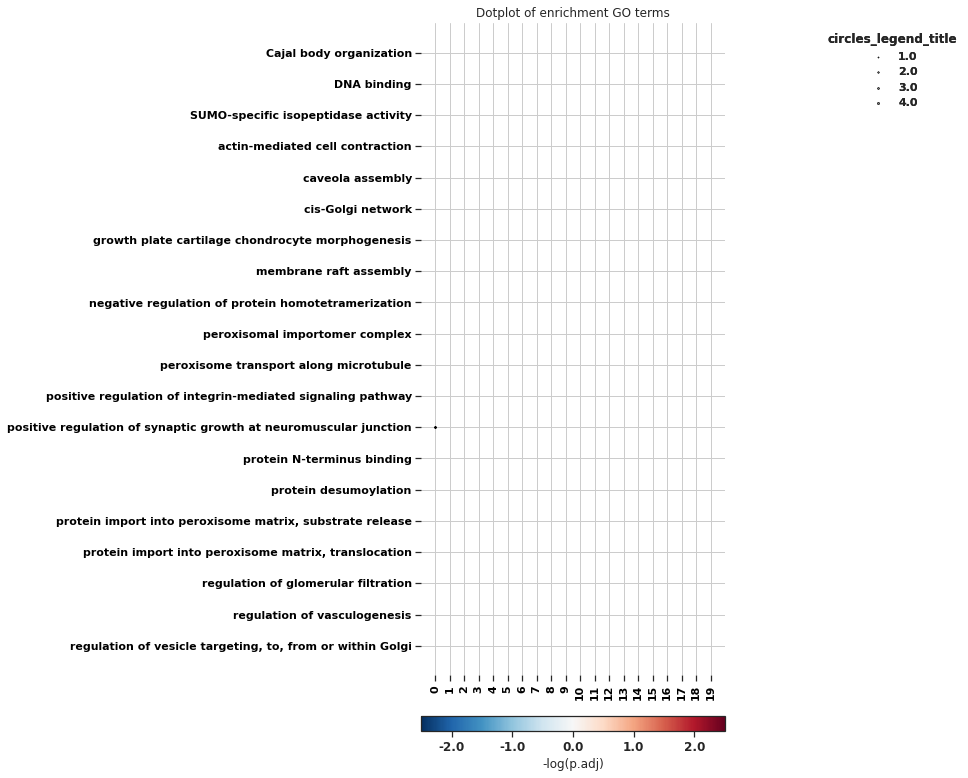

In [10]:
fig = plt.figure(figsize=(25, 15))
make_bubble_heatmap(test2,od_r,circle_legend_ticks=[1, 2, 3, 4], ylab='',xlab='', tickscolorbar=[-2, -1, 0, 1, 2], cbar_label='-log(p.adj)',
                                   marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",
                                   legends_heatmap_ticks=[1, 5, 10, 20], fig=fig)

In [11]:
import bindome as bd 

In [11]:
annpath = "../../annotation/"
bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath
df = bd.bindome.datasets.REMAP2020.get_remap_peaks('SRF')
# import pandas as pd
# name = pd.unique(list(df[3]))
# for n in name : 
#     if df[df[3]==n].shape[0] < 150 and df[df[3]==n].shape[0] > 50 : 
#         print(df[df[3]==n].shape[0],n)

In [88]:
test = ["SRF:Ishikawa,MCF-7,HCT-116","SRF:Ishikawa,GM12878,A-673-clone-Asp114,K-562,MCF-7","SRF:Hep-G2,K-562","SRF:Ishikawa,GM12878,K-562","SRF:Ishikawa,GM12878,K-562,WA01,MCF-7,Hep-G2","SRF:K-562,Hep-G2","SRF:Ishikawa,GM12878,WA01,Hep-G2","SRF:Ishikawa,GM12878,A-673-clone-Asp114,WA01,MCF-7,HCT-116,Hep-G2","SRF:WA01,K-562"]
len(test)

9

In [12]:
df1 = df[df[3]=="SRF:Ishikawa,MCF-7,HCT-116"].iloc[:,0:3]
df1 = df1.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

In [13]:
df1 = great.tl.GREAT.enrichment(
    test_file = df1,
    regdom_file="../data/human/hg38/regulatory_domain.bed",
    chr_size_file="../data/human/hg38/chr_size.bed",
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )
great.tl.GREAT.set_fdr(df1)
great.tl.GREAT.set_bonferroni(df1)

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall,binom_fdr,hypergeom_fdr,binom_bonferroni,hypergeom_bonferroni
GO:0007160,cell-matrix adhesion,5.60820e-05,7.74335e+02,4.41432e-04,6.16144e+00,6,5.21739e-02,5.64090e-02,8.46752e-02,9.65171e-02,7.59705e-01
GO:0002675,positive regulation of acute inflammatory resp...,8.91070e-05,3.04272e+03,4.82113e-05,3.93648e+01,3,3.33333e-01,5.64090e-02,4.14859e-02,1.53353e-01,8.29717e-02
GO:0045095,keratin filament,1.79547e-04,2.39596e+03,1.18311e-02,4.54209e+00,3,2.88462e-02,5.64090e-02,1.48977e-01,3.09001e-01,1.00000e+00
GO:0035148,tube formation,2.13801e-04,2.25693e+03,4.82113e-05,3.93648e+01,3,3.33333e-01,5.64090e-02,4.14859e-02,3.67952e-01,8.29717e-02
GO:0030308,negative regulation of cell growth,2.26834e-04,5.97915e+02,9.87443e-04,5.28781e+00,6,4.47761e-02,5.64090e-02,1.07125e-01,3.90382e-01,1.00000e+00
...,...,...,...,...,...,...,...,...,...,...,...
GO:0008283,cell proliferation,9.45133e-01,2.97844e+01,9.61457e-01,3.11595e-01,1,2.63852e-03,9.47335e-01,9.75055e-01,1.00000e+00,1.00000e+00
GO:0005575,cellular_component,9.52230e-01,2.84511e+01,9.84547e-01,2.43997e-01,1,2.06612e-03,9.53892e-01,9.93603e-01,1.00000e+00,1.00000e+00
GO:0006508,proteolysis,9.52783e-01,2.83445e+01,9.95096e-01,1.92023e-01,1,1.62602e-03,9.53892e-01,9.99743e-01,1.00000e+00,1.00000e+00
GO:0004930,G protein-coupled receptor activity,9.66628e-01,2.55031e+01,9.98858e-01,1.51403e-01,1,1.28205e-03,9.67190e-01,1.00000e+00,1.00000e+00,1.00000e+00


In [14]:
df2 = df[df[3]=="SRF:Hep-G2,K-562"].iloc[:,0:3]
df2 = df2.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

In [15]:
df2 = great.tl.GREAT.enrichment(
    test_file = df2,
    regdom_file="../data/human/hg38/regulatory_domain.bed",
    chr_size_file="../data/human/hg38/chr_size.bed",
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )
great.tl.GREAT.set_fdr(df2)
great.tl.GREAT.set_bonferroni(df2)

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall,binom_fdr,hypergeom_fdr,binom_bonferroni,hypergeom_bonferroni
GO:0050201,fucokinase activity,1.96870e-06,5.48938e+04,1.41530e-02,7.03258e+01,2,6.66667e-01,5.23019e-04,1.35903e-01,1.56906e-03,1.00000e+00
GO:0042352,GDP-L-fucose salvage,1.96870e-06,5.48938e+04,4.73984e-03,2.10978e+02,2,2.00000e+00,5.23019e-04,1.21574e-01,1.56906e-03,1.00000e+00
GO:1903350,response to dopamine,1.96870e-06,5.48938e+04,4.73984e-03,2.10978e+02,2,2.00000e+00,5.23019e-04,1.21574e-01,1.56906e-03,1.00000e+00
GO:1905426,positive regulation of Wnt-mediated midbrain d...,9.57608e-06,2.48704e+04,9.45747e-03,1.05489e+02,2,1.00000e+00,1.83688e-03,1.21574e-01,7.63214e-03,1.00000e+00
GO:0050321,tau-protein kinase activity,1.15237e-05,3.90738e+03,8.29955e-03,1.45502e+01,3,1.03448e-01,1.83688e-03,1.21574e-01,9.18442e-03,1.00000e+00
...,...,...,...,...,...,...,...,...,...,...,...
GO:0030154,cell differentiation,9.63079e-01,1.71769e+01,9.32541e-01,3.77420e-01,1,1.78891e-03,9.67936e-01,9.63988e-01,1.00000e+00,1.00000e+00
GO:0009986,cell surface,9.75029e-01,1.54106e+01,9.81290e-01,2.57604e-01,1,1.22100e-03,9.78713e-01,9.93449e-01,1.00000e+00,1.00000e+00
GO:0045893,"positive regulation of transcription, DNA-temp...",9.77039e-01,1.50793e+01,9.82019e-01,2.55112e-01,1,1.20919e-03,9.79497e-01,9.93449e-01,1.00000e+00,1.00000e+00
GO:0005509,calcium ion binding,9.87540e-01,1.30487e+01,9.80239e-01,2.61111e-01,1,1.23762e-03,9.88781e-01,9.93449e-01,1.00000e+00,1.00000e+00


In [16]:
nb = 5 
d1 = df1.iloc[:nb].reset_index().rename(columns={"index":"id"})
d1["index"] = [0]*nb
d2 = df2.iloc[:nb].reset_index().rename(columns={"index":"id"})
d2["index"] = [1]*nb
res = pd.concat([d1,d2])
res
res["hypergeom_p_value"] = -np.log10(res["hypergeom_p_value"])
res["hypergeometric_fold_enrichment"] = np.log2(res["hypergeometric_fold_enrichment"])

p_val = res.pivot("id","index","hypergeom_p_value").fillna(1)
odd_ratio = res.pivot("id","index","hypergeometric_fold_enrichment").fillna(0)

p_val

index,0,1
id,,
GO:0002675,4.31685e+00,1.00000e+00
GO:0007160,3.35514e+00,1.00000e+00
GO:0030308,3.00549e+00,1.00000e+00
GO:0035148,4.31685e+00,1.00000e+00
GO:0042352,1.00000e+00,2.32424e+00
GO:0045095,1.92698e+00,1.00000e+00
GO:0050201,1.00000e+00,1.84915e+00
GO:0050321,1.00000e+00,2.08095e+00
GO:1903350,1.00000e+00,2.32424e+00


In [33]:
odd_ratio

index,0,1
id,,
GO:0002675,5.29883e+00,0.00000e+00
GO:0007160,2.62327e+00,0.00000e+00
GO:0030308,2.40267e+00,0.00000e+00
GO:0035148,5.29883e+00,0.00000e+00
GO:0042352,0.00000e+00,7.72095e+00
GO:0045095,2.18336e+00,0.00000e+00
GO:0050201,0.00000e+00,6.13598e+00
GO:0050321,0.00000e+00,3.86296e+00
GO:1903350,0.00000e+00,7.72095e+00


In [18]:
min_p = 100
max_p = 0
for i in p_val.columns : 
    if min_p > p_val[i].min() : 
        min_p = p_val[i].min()
    if max_p < p_val[i].max() : 
        max_p = p_val[i].max()

min_od = 100
max_od = 0 

for i in odd_ratio.columns : 
    if min_od > odd_ratio[i].min() : 
        min_od = odd_ratio[i].min()
    if max_od < odd_ratio[i].max() : 
        max_od = odd_ratio[i].max()
min_od,max_od

(0.0, 7.720945530698637)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors, rcParams
from numpy import log

import greatpy as gp


def scatterplot(
    great_df: pd.DataFrame, colname_x: str, colname_y: str,
    title: str = "", minus_log10=True, ax=None
) -> None:
    """
    Create a scatterplot from a
    pandas dataframe between two columns.
    A logarithmic scale can be used.

    Parameters
    ----------
    great_df : pd.DataFrame
        Output of the greatpy.tl.GREAT.enrichment function
    colname_x : str
        Name of the column to be used as x axis
    colname_y : str
        Name of the column to be used as y axis
    title : str
        Title of the plot
    minus_log10 : bool
        If True, the logarithmic scale is used
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    great_df = great_df.dropna()
    great_df = great_df.astype({colname_x: "float64", colname_y: "float64"})
    if minus_log10:
        great_df[f"-log({colname_x})"] = -log(great_df[colname_x])
        great_df[f"-log({colname_y})"] = -log(great_df[colname_y])
        sns.scatterplot(data=great_df, x=f"-log({colname_x})", y=f"-log({colname_y})", ax=ax).set_title(title)
    else:
        sns.scatterplot(data=great_df, x=colname_x, y=colname_y, ax=ax).set_title(title)

def graph_nb_asso_per_peaks(
    test: str or pd.DataFrame, regdom: str or pd.DataFrame,
    ax=None, color=None) -> None:
    """
    Creates a barplot representing the
    percentage of peaks for all possible association numbers

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    nb_asso_per_peaks = gp.tl.get_nb_asso_per_region(test, regdom)

    nb = {
        "number": [],
        "number_genes": [],
        "percentage": [],
    }
    for i in list(set(nb_asso_per_peaks.values())):
        nb["number"].append(i)
        nb["number_genes"].append(list(nb_asso_per_peaks.values()).count(i))
        nb["percentage"].append(
            round((list(nb_asso_per_peaks.values()).count(i) / len(nb_asso_per_peaks.keys())) * 100)
        )
    nb = pd.DataFrame(nb, columns=["number", "number_genes", "percentage"], index=nb["number"])

    g = sns.barplot(data=nb, x="number", y="percentage", ax=ax, color=color)
    g.set_title("Number of associated genes per region", fontsize=20)
    g.set_xlabel("Number of associated genes per region", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)

    for i in range(nb.shape[0]):
        x = nb.iloc[i]["number"]
        y = nb.iloc[i]["percentage"]
        g.text(x=x - 0.06, y=y + 1, s=nb.number_genes[0])

def graph_dist_tss(
    test: str or pd.DataFrame, regdom: str or pd.DataFrame, 
    ax=None, color="#325fa8") -> None:
    """
    Creation of a barplot of the distance
    between the peaks and the TSS of the associated gene(s).

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    res = {
        "<-500": [0],
        "-500:-50": [0],
        "-50:-5": [0],
        "-5:0": [0],
        "0:5": [0],
        "5:50": [0],
        "50:500": [0],
        ">500": [0],
    }
    nb = 0

    dist = gp.tl.get_dist_to_tss(test, regdom)
    for i in dist.values():
        for j in i:
            if j < -500000:
                res["<-500"][0] += 1
            elif j < -50000:
                res["-500:-50"][0] += 1
            elif j < -5000:
                res["-50:-5"][0] += 1
            elif j < 0:
                res["-5:0"][0] += 1
            elif j < 5000:
                res["0:5"][0] += 1
            elif j < 50000:
                res["5:50"][0] += 1
            elif j < 500000:
                res["50:500"][0] += 1
            else:
                res[">500"][0] += 1
            nb += 1
    df = pd.DataFrame(res).transpose().rename(columns={0: "count"})
    df["percentage"] = (df["count"] / nb) * 100
    df = df.reset_index(drop=False).rename(columns={"index": "distance"})
    g = sns.barplot(data=df, x="distance", y="percentage", color=color, ax=ax)
    for idx, p in enumerate(g.patches):
        g.annotate(str(df.iloc[idx]["count"]), (p.get_x() + p.get_width() / 2, p.get_height()))
    g.set_xlabel("Distance to TSS (kb)", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)
    g.set_title("Binned by absolute distance to TSS", fontsize=20)

def graph_absolute_dist_tss(
    test: str or pd.DataFrame, regdom: str or pd.DataFrame, 
    ax=None, color="#325fa8") -> None:
    """
    Creation of a barplot of the absolute
    distance between the peaks and the TSS of the associated gene(s).

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    res = {"0:5": [0], "5:50": [0], "50:500": [0], ">500": [0]}
    nb = 0
    dist = gp.tl.get_dist_to_tss(test, regdom)

    for i in dist.values():
        for j in i:
            j = abs(j)
            if j < 5000:
                res["0:5"][0] += 1
            elif j < 50000:
                res["5:50"][0] += 1
            elif j < 500000:
                res["50:500"][0] += 1
            else:
                res[">500"][0] += 1
            nb += 1
    df = pd.DataFrame(res).transpose().rename(columns={0: "count"})
    df["percentage"] = (df["count"] / nb) * 100
    df = df.reset_index(drop=False).rename(columns={"index": "distance"})
    g = sns.barplot(data=df, x="distance", y="percentage", color=color, ax=ax)
    for idx, p in enumerate(g.patches):
        g.annotate(str(df.iloc[idx]["count"]), (p.get_x() + p.get_width() / 2, p.get_height()))
    g.set_xlabel("Absolute distance to TSS (kb)", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)
    g.set_title("Binned by absolute distance to TSS", fontsize=20)


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)

    if maxd == mind:
        maxd = maxd + 1
        mind = mind - 1

    drange = maxd - mind
    return (((data - mind) / drange * 0.70) + 0.05) * 100


def plot_enrich(data, n_terms=20, color="cool", save=False):
    """
    Creation of a dotplot of the enrichment
    GO term in the inputs datas

    Parameters
    ----------
    data : pd.DataFrame
        Results for greatpy
    n_terms : int
        the number of term to be shown
    color : str
        The color of the cmap in the plot
    save : bool
        Is the plot should be save

    Returns
    -------
    None

    """
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Please input a Pandas Dataframe output by gprofiler.")

    if not np.all([term in data.columns for term in ["p_value", "name", "intersection_size"]]):
        raise TypeError(f"The data frame {data} does not contain enrichment results from gprofiler.")

    data_to_plot = data.iloc[:n_terms, :].copy()
    data_to_plot["go.id"] = data_to_plot.index

    min_pval = data_to_plot["p_value"].min()
    max_pval = data_to_plot["p_value"].max()

    # Scale intersection_size to be between 5 and 75 for plotting
    # Note: this is done as calibration was done for values between 5 and 75
    data_to_plot["scaled.overlap"] = scale_data_5_75(data_to_plot["intersection_size"])

    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    rcParams.update({"font.size": 14, "font.weight": "bold"})

    sns.set(style="whitegrid")

    path = plt.scatter(
        x="recall",
        y="name",
        c="p_value",
        cmap=color,
        norm=colors.LogNorm(min_pval, max_pval),
        data=data_to_plot,
        linewidth=1,
        edgecolor="grey",
        s=[(i + 10) ** 1.5 for i in data_to_plot["scaled.overlap"]],
    )
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel("")
    ax.set_xlabel("Gene ratio", fontsize=14, fontweight="bold")
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    # Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick) / 6).astype(int)

    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick - 1

    ticks_vals = [10**i for i in range(max_tick, min_tick - 1, -tick_step)]
    ticks_labs = ["$10^{" + str(i) + "}$" for i in range(max_tick, min_tick - 1, -tick_step)]

    # Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0, 0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight="bold")

    # Size legend
    min_olap = data_to_plot["intersection_size"].min()
    max_olap = data_to_plot["intersection_size"].max()
    olap_range = max_olap - min_olap

    # Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [
        np.ceil(i / 5) * 5
        for i in [min_olap, min_olap + (20 / 70) * olap_range, min_olap + (45 / 70) * olap_range, max_olap]
    ]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    l1 = plt.scatter([], [], s=(size_leg_scaled_vals[0] + 10) ** 1.5, edgecolors="none", color="black")
    l2 = plt.scatter([], [], s=(size_leg_scaled_vals[1] + 10) ** 1.5, edgecolors="none", color="black")
    l3 = plt.scatter([], [], s=(size_leg_scaled_vals[2] + 10) ** 1.5, edgecolors="none", color="black")
    l4 = plt.scatter([], [], s=(size_leg_scaled_vals[3] + 10) ** 1.5, edgecolors="none", color="black")

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend(
        [l1, l2, l3, l4],
        labels,
        ncol=1,
        frameon=False,
        fontsize=12,
        handlelength=1,
        loc="center left",
        borderpad=1,
        labelspacing=1.4,
        handletextpad=2,
        title="Gene overlap",
        scatterpoints=1,
        bbox_to_anchor=(-2, 1.5),
        facecolor="black",
    )

    if save:
        plt.savefig("dotplot_save", dpi=500)

    plt.show()

import matplotlib
from matplotlib import rc 

def make_bubble_heatmap(order_frame, sizeDict, na_color='gray', title='title',
                        tickscolorbar=[-2, -1, 0, 1, 2], vmin=-2.5, vmax=2.5,
                        heatmap_grid=[2, 4, 0, 2, 2, 1],
                        circle_legend_grid=[2, 4, 0, 2, 2, 1],
                        colorbar_grid=[2, 5, 0, 3, 2, 1],
                        palette_id='RdBu_r', cbar_label='cbar_label', ncols=8,
                        marker=None, **kwargs):
    """
    Generate a dotplot with multiple categories

    Parameters
    ----------
    order_frame
        DataFrame with gene ontologies 
    sizeDict
        Dictionary with gene ontologies as keys and sizes as values
    na_color
        Color for NA values
    title
        Title for the plot
    tickscolorbar
        Tick marks for the colorbar
    vmin
        Minimum value for the colorbar
    vmax
        Maximum value for the colorbar
    heatmap_grid
        Grid for the heatmap
    circle_legend_grid
        Grid for the circle legend
    colorbar_grid
        Grid for the colorbar
    palette_id
        Palette id for the colorbar
    cbar_label
        Label for the colorbar
    ncols
        Number of columns for the colorbar
    marker
        Marker for the dots
    kwargs
        Additional keyword arguments for the plot

    Returns
    -------
    None 
        Bubble heatmap plot for gene ontology
    """
    from matplotlib import gridspec
    sns.set_style('white')

    rc("font",weight="normal")
    rc("alpha",alpha=0.8)

    quantAmplifier = kwargs.get('quantAmplifier', 1) #factor for size of bubbles

    #function you received on the color gradient
    pallete = None
    if palette_id == 'RdBu_r':
        pallete = plt.cm.RdBu_r
    elif palette_id == 'Blues':
        pallete = plt.cm.Blues
    elif palette_id == 'Reds':
        pallete = plt.cm.Reds
    elif palette_id == 'Greens':
        pallete = plt.cm.Greens
    elif palette_id == 'Purples':
        pallete = plt.cm.Purples
    elif palette_id == 'YlGnBu':
        pallete = plt.cm.YlGnBu
    elif palette_id == 'PuOr':
        pallete = plt.cm.PuOr
    else:
        palette = palette_id
    scalarmap,colorList = get_specific_color_gradient(pallete,
        np.array(order_frame),
        vmin=vmin,
        vmax=vmax)

    fig = kwargs.get('fig', None)
    if fig is None:
        plt.clf()
        fig = plt.figure(figsize=(kwargs.get('w', 11), kwargs.get('h', 5)))


    nrows, ncols, rowi, coli, rowspan, colspan = heatmap_grid
    gs = gridspec.GridSpec(nrows, ncols)
    ax = plt.subplot(gs[rowi: rowi + rowspan, coli: coli + colspan])

    ylabelList = []
    i = 0

    # to keep the order of dataframes in the same order as sizes, revert the dataframes
    order_frame = order_frame.reindex(index=order_frame.index[::-1])
    sizeDict = sizeDict.reindex(index=sizeDict.index[::-1])

    min_circle_size = kwargs.get('min_circle_size')
    max_circle_size = kwargs.get('max_circle_size')

    for ri, r in order_frame.iterrows():
        patList = list(r.values)

        sizeList = []
        if min_circle_size is not None and max_circle_size is not None:
            for si in list(sizeDict.loc[ri]):
                if si < min_circle_size:
                    si = min_circle_size
                scaled = (si - min_circle_size) / (max_circle_size - min_circle_size)
                sizeList.append(scaled * quantAmplifier)
        else:
            sizeList = [(si ** kwargs.get('power', 1.0)) * (quantAmplifier) for si in list(sizeDict.loc[ri])]

        colorList = scalarmap.to_rgba(patList)
        colorList = [ci if not np.isnan(vi) else na_color
                        for ci, vi in zip(colorList, patList)]
        edgecolorList = list()
        x = list(range(len(patList)))
        y = [i] * len(patList)

        # define hataches, linewidths and alphas
        hatches = [None if np.isnan(pi) else None for pi in patList]
        linewidths = [0.1 if np.isnan(pi) else kwargs.get('sig_line_width', 2.0) for pi in patList]\
            if kwargs.get('line_widths', None) is None else list(kwargs.get('line_widths').loc[ri])
        alphas = [.5 if np.isnan(alpha) else 1.0 for alpha in patList]

        for xi, yi, si, ci, hatch_i,lw, alpha in zip(x, y, sizeList, colorList,hatches, linewidths, alphas):
            ax.scatter(xi, yi, s=abs(si) * quantAmplifier,
                        marker=marker if marker is not None else ('v' if si < 0 else '^'),
                        hatch=hatch_i, alpha=alpha,
                        edgecolor=kwargs.get('edgecolor', 'black'), color=ci, linewidth=lw)
        ylabelList.append(ri)
        i += 1
    if kwargs.get('grid', True):
        plt.grid(True, linewidth=kwargs.get('grid_linewidth', 1.0))
    plt.title(kwargs.get('heatmap_title', 'title'), fontname='Arial',fontweight='normal')
    plt.xlabel(kwargs.get('xlab', 'xlab'), fontsize=14,fontname='Arial',fontweight='normal')
    plt.ylabel(kwargs.get('ylab', 'ylab'), fontsize=14,fontname='Arial',fontweight='normal')


    plt.yticks(list(range(len(ylabelList))))
    ax.set_yticklabels(ylabelList, fontsize=kwargs.get('yticks_fontsize', 11), color="black",
                        ha=kwargs.get('ha_ylabs', 'right'),fontname='Arial',fontweight='normal')
    remove_top_n_right_ticks(ax)

    plt.xticks(list(range(len(order_frame.columns))), order_frame.columns,
                fontsize=kwargs.get('xticks_fontsize', 11), rotation=kwargs.get('rotation_xlabs', 90), color="black",
                ha=kwargs.get('ha_xlabs', 'center'),fontname='Arial',fontweight='normal')

    lh, lt = get_legendHandle_for_second_sanity_check_plot(quantAmplifier=quantAmplifier * quantAmplifier,
                                                            marker='^' if marker is None else marker,
                                                            fmt=kwargs.get('fmt_legend', '%.1f'),
                                                            lw=0.5,
                                                            min_circle_size=min_circle_size,
                                                            max_circle_size=max_circle_size,
                                                            values=[tick ** kwargs.get('power', 1.0) for tick in kwargs.get('circle_legend_ticks')],
                                                            labels=kwargs.get('circle_legend_ticks'))
    if kwargs.get('show_circle_legend', True):
        l = plt.legend(lh, lt, bbox_to_anchor=kwargs.get('circle_legend_bbox', (1.8, 1)), scatterpoints=1,
                        title=kwargs.get('circles_legend_title', 'circles_legend_title'), ncol=1,
                        frameon=False)
        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(l)

    # this is to add the circle (significant or not
    if kwargs.get('show_sig_legend', False):
        lh, lt = get_legendHandle_for_second_sanity_check_plot(quantAmplifier=quantAmplifier * quantAmplifier,
                                                                marker='^' if marker is None else marker,
                                                                fmt=kwargs.get('sig_fmt_legend', '%s'),
                                                                lw=[kwargs.get('sig_line_width', 2.0), 0.0],
                                                                labels=kwargs.get('sig_legend_ticks',
                                                                                    ['Yes', 'No']),
                                                                values=kwargs.get('sig_legend_ticks',
                                                                                    ['Yes', 'No']),
                                                                edgecolor=kwargs.get('edgecolor', 'black'),
                                                                min_size_default=max(kwargs.get('circle_legend_ticks')) ** kwargs.get('power', 1.0))

        plt.legend(lh, lt, bbox_to_anchor=kwargs.get('sig_legend_bbox', (2.4, 1)),
                    title=kwargs.get('sig_legend_title', 'significant'), ncol=1, scatterpoints=1,
                    frameon=False)
    
    # nrows, ncols, rowi, coli, rowspan, colspan = colorbar_grid
    # plt.show()
    # ax1 = plt.subplot2grid([nrows, ncols], [rowi, coli], rowspan=rowspan, colspan=colspan)
    
    # plt.axis('off')
    # ax1.set_xticklabels([])
    # ax1.set_yticklabels([])

    # fontproperties = {'family': 'Arial',"weight": "normal"}

    if kwargs.get('show_colorbar', True):
        cbar = fig.colorbar(scalarmap, orientation="horizontal", format=kwargs.get('cbar_fmt_ticks', "%.1f"),
                            ticks = tickscolorbar,pad=0.05)
        cbar.ax.tick_params(labelsize=kwargs.get('colorbar_ticks_labelsize', 12))
        cbar.set_label(cbar_label, fontsize=12,fontweight='normal')
    despine_all()

def get_specific_color_gradient(colormap,inputList,**kwargs):
    vmin = kwargs.get('vmin','blaq')
    vmax = kwargs.get('vmax','blaq')
    cm = plt.get_cmap(colormap)
    if vmin=='blaq' or vmax=='blaq':
        if type(inputList)==list:
            cNorm = matplotlib.colors.Normalize(vmin=min(inputList), vmax=max(inputList))
        else:
            cNorm = matplotlib.colors.Normalize(vmin=inputList.min(), vmax=inputList.max())
    else:
        cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax = vmax)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(inputList)
    colorList=scalarMap.to_rgba(inputList)
    return scalarMap,colorList

def despine_all():
    sns.despine(offset=10, trim=True, top=True, right=True, left=True,
                bottom=True)

def remove_top_n_right_ticks(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

def get_legendHandle_for_second_sanity_check_plot(quantAmplifier=None,
                                                  labels=None,
                                                  values=None,
                                                  marker='^',
                                                  fmt='%.1f',
                                                  lw=2.0, min_circle_size=None, max_circle_size=None,
                                                  min_size_default=1.0,
                                                  edgecolor='black',
                                                  color='grey'):
    labels = [0.1, 0.5, 1.0, 1.5] if labels is None else labels

    legendHandleList = list()
    labelSize = list()
    for i, quantMem in enumerate(values):
        v = values[i]

        if min_circle_size is not None and max_circle_size is not None:
            scaled = (quantMem - min_circle_size) / (max_circle_size - min_circle_size)
            quantMem = scaled

        next_size = (quantMem * quantAmplifier) if not isinstance(quantMem, str) else min_size_default * quantAmplifier

        legendHandleList.append(plt.scatter([], [], s=next_size,
                                            color=color, edgecolor=edgecolor,
                                            linewidths=lw if not isinstance(lw, list) else lw[i],
                                            alpha=0.9, marker=marker))
        labelSize.append(fmt % labels[i])
    return legendHandleList, labelSize

In [42]:
fig = plt.figure(figsize=(25, 15))
make_bubble_heatmap(
    p_val,odd_ratio,quantAmplifier = 7,circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],palette_id="Reds",
    ylab='',xlab='', tickscolorbar=[i for i in range(round(min_p),round(max_p)+1)],vmin=min_p,vmax=max_p, cbar_label='-log(p_hypergeometric)',
    marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",sig_line_width=0.1,
    fig=fig
    )

KeyError: 'Unrecognized key "alpha.alpha" for group "alpha" and name "alpha"'

<Figure size 1800x1080 with 0 Axes>

In [89]:
import time
test = ["SRF:Ishikawa,MCF-7,HCT-116","SRF:Ishikawa,GM12878,A-673-clone-Asp114,K-562,MCF-7",
    "SRF:Hep-G2,K-562","SRF:Ishikawa,GM12878,K-562","SRF:Ishikawa,GM12878,K-562,WA01,MCF-7,Hep-G2",
    "SRF:K-562,Hep-G2","SRF:Ishikawa,GM12878,WA01,Hep-G2","SRF:Ishikawa,GM12878,A-673-clone-Asp114,WA01,MCF-7,HCT-116,Hep-G2",
    "SRF:WA01,K-562"]


def dotplot(test_data, n_row:int = 5): 
    """
    Dotplot of enrichment GO terms for a given list of example genomic regions.

    Parameters
    ----------
    n_row : int
        Number of rows pick in each dataframe. 
    test_data : list
        List of biosample in SRF to be tested.

    Returns
    -------
    None.


    """
    srf = bd.bindome.datasets.REMAP2020.get_remap_peaks('SRF')
    df = pd.DataFrame()
    for i,name in enumerate(test_data) :
        tmp = srf[srf[3]==name].iloc[:,0:3]
        tmp = tmp.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

        print(i)

        res = great.tl.GREAT.enrichment(
            test_file = tmp,
            regdom_file="../data/human/hg38/regulatory_domain.bed",
            chr_size_file="../data/human/hg38/chr_size.bed",
            annotation_file="../data/human/ontologies.csv",
            binom=True,
            hypergeom=True,
            ).sort_values(by="hypergeom_p_value").iloc[:n_row]
        res = res.reset_index().rename(columns={"index":"id"})
        res["index"] = [i]*n_row
        frames = [df, res]
        df = pd.concat(frames)

        if i == 1 : return df

        time.sleep(30)


    df["hypergeom_p_value"] = np.log(df["hypergeom_p_value"])
    df["hypergeometric_fold_enrichment"] = np.log2(df["hypergeometric_fold_enrichment"])

    p_val = df.pivot("id","index","hypergeom_p_value").fillna(1)
    odd_ratio = df.pivot("id","index","hypergeometric_fold_enrichment").fillna(0)

    min_p = 100
    max_p = 0
    for i in p_val.columns : 
        if min_p > p_val[i].min() : 
            min_p = p_val[i].min()
        if max_p < p_val[i].max() : 
            max_p = p_val[i].max()

    min_od = 100
    max_od = 0 

    for i in odd_ratio.columns : 
        if min_od > odd_ratio[i].min() : 
            min_od = odd_ratio[i].min()
        if max_od < odd_ratio[i].max() : 
            max_od = odd_ratio[i].max()
    
    fig = plt.figure(figsize=(25, 15))
    make_bubble_heatmap(
        p_val,odd_ratio,quantAmplifier = 7,circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],
        ylab='',xlab='', tickscolorbar=[i for i in range(round(min_p),round(max_p)+1)], cbar_label='-log(p_hypergeometric)',
        marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",
        legends_heatmap_ticks=[10, 50, 100, 200, 400, 800], fig=fig
        )

dotplot(test)

0


,id,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall,index
0,GO:0002675,positive regulation of acute inflammatory resp...,8.91070e-05,3.04272e+03,4.82113e-05,3.93648e+01,3,3.33333e-01,0
1,GO:0035148,tube formation,2.13801e-04,2.25693e+03,4.82113e-05,3.93648e+01,3,3.33333e-01,0
2,GO:0045779,negative regulation of bone resorption,2.56946e-04,2.11905e+03,1.23928e-04,2.95236e+01,3,2.50000e-01,0
3,GO:0043122,regulation of I-kappaB kinase/NF-kappaB signaling,4.04045e-04,1.81342e+03,3.71311e-04,2.08402e+01,3,1.76471e-01,0
4,GO:0072012,glomerulus vasculature development,2.31677e-03,2.42687e+03,4.22787e-04,5.90472e+01,2,5.00000e-01,0
